In [1]:
%load_ext autoreload
%autoreload 1
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

In [2]:
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
import timm
from timm import optim, scheduler
import torch
from torchvision import transforms as tfm
from sklearn import metrics as skmet
import matplotlib.pyplot as plt
import json
import transforms as my_transforms

%aimport dataset
%aimport models
VideoClassifier = models.VideoClassifier
VideoData = dataset.VideoData

In [3]:
artifact_folder = '/zfs/wficai/pda/model_run_artifacts/aihub_results_SAVE'
# artifact_folder = '/zfs/wficai/pda/model_run_artifacts/20220818_all_224x224'

with open(artifact_folder + '/config_video.json', 'r') as f: 
    cfg = json.load(f)

# put all config variables in scope to avoid the need to laboriously index cfg
for k, v in cfg.items():
    v = f"'{v}'" if type(v)==str else v
    exec(f"{k}={v}")

In [4]:
# optionally override the view/mode filters
view_filter = ['pdaView', 'pdaRelatedView']
mode_filter = ['2d', 'color', 'color_compare']

In [5]:
tfms = my_transforms.VideoTransforms(res)
tfms_test = tfms.get_transforms(transforms['test'])

In [6]:
df_test = pd.read_csv(f'{artifact_folder}/{out_paths["test"]}')
d_test = VideoData(df_test, transforms = tfms_test, mode_filter = mode_filter, view_filter = view_filter)
dl_test = DataLoader(d_test, batch_size=bs_test, num_workers=num_workers, collate_fn = VideoData.collate)

print("Number of frames after filtering:", len(d_test.data))

Number of frames after filtering: 16973


In [7]:
# create frame model
m_frames = timm.create_model(model, num_classes=num_classes, in_chans=3, drop_rate=dropout)
_ = m_frames.to(device)

# create video model
m = VideoClassifier(m_frames)

# load checkpoint
m.load_state_dict(torch.load(f"{artifact_folder}/model_checkpoint_video.ckpt"))

<All keys matched successfully>

In [8]:
loss_function = torch.functional.F.binary_cross_entropy_with_logits

target_ls = []
output_ls = []
study_ls = []
mask_ls = []
externalid_ls = []
view_ls = []
mode_ls = []
losses = []
attn_ls = []

for ix, batch in enumerate(dl_test):
    print(f"Batch {ix+1}", end = "\r")
    vid = batch['video'].to(device)
    mask = batch['mask'].to(device)
    targets = batch['trg_type'].to(device).type(torch.float32)
    
    target_ls.append(targets.cpu().numpy())
    view_ls.append(batch['trg_view'].numpy())
    mode_ls.append(batch['trg_mode'].numpy())
    study_ls += batch['study']
    mask_ls.append(batch['mask'].numpy())
    externalid_ls += batch['external_id']

    with torch.no_grad():
        outputs, attn = m(vid, mask)
        output_ls.append(outputs.cpu().numpy())
        attn_ls.append(attn.cpu().numpy())
        loss = loss_function(outputs, targets)
        losses.append(loss.detach().item())

In [9]:
df_results = pd.DataFrame(dict(
    study = study_ls,
    external_id = externalid_ls,
    predicted = np.concatenate(output_ls).squeeze(),
    target = np.concatenate(target_ls), 
    mode = np.concatenate(mode_ls),
    view = np.concatenate(view_ls)
))

df_results['mode'] = df_results['mode'].map(VideoData.inv_mode_map)
df_results.view = df_results.view.map(VideoData.inv_view_map)

# Attention

In [18]:
df_results.query('target==0.0 and mode=="color" and view=="pdaView"')

,study,external_id,predicted,target,mode,view
3,study24,study24_dicom117,0.086322,0.0,color,pdaView
27,study69,study69_dicom94,0.080704,0.0,color,pdaView
38,study27,study27_dicom62,0.063459,0.0,color,pdaView
46,study59,study59_dicom113,0.112721,0.0,color,pdaView
86,study2,study2_dicom3,0.171996,0.0,color,pdaView
97,study37,study37_dicom96,0.137148,0.0,color,pdaView
101,study37,study37_dicom84,0.034202,0.0,color,pdaView
135,study57,study57_dicom61,0.102898,0.0,color,pdaView
149,study32,study32_dicom83,0.008983,0.0,color,pdaView
156,study28,study28_dicom28,0.144379,0.0,color,pdaView


### PDA Plot

study36_dicom45 - pda - pdaView


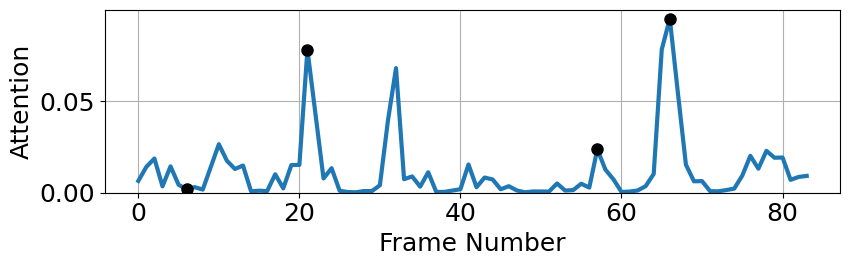

In [20]:
index = 115
batch_ix = index // bs_test
ix_in_batch = index % bs_test

mask = mask_ls[batch_ix][...,ix_in_batch]
attn = attn_ls[batch_ix][...,ix_in_batch]
trg_type = int(target_ls[batch_ix][ix_in_batch])
target = VideoData.inv_type_map[trg_type]
view = VideoData.inv_view_map[int(view_ls[batch_ix][ix_in_batch])]
external_id = externalid_ls[index]

mp4_path = df_test.loc[(df_test.external_id == external_id) & (df_test.trg_type == trg_type)].mp4_path.unique().item()
mp4_path = mp4_path.replace('/Superior Views/', '/superior_views_h264/')

print(external_id, target, view, sep=' - ')

plt.rcParams['font.size']=18
points = [6, 21, 57, 66]
plt.plot(attn[mask], linewidth=3)
plt.plot(points, attn[mask][points], 'ko', markersize=8)
plt.ylim(0,None)
plt.xlabel("Frame Number")
plt.ylabel("Attention")
plt.gcf().set_size_inches(9,3)
plt.grid()
plt.tight_layout()
plt.savefig('/home/dane2/Code/pda_detection/attention.png', dpi=500)
plt.show()

images = \
    df_test.loc[(df_test.external_id == external_id) & (df_test.trg_type == trg_type), 'png_path'].\
    sort_values().iloc[points].tolist()

# save images
import shutil
for im in images:
    shutil.copy(im, '/home/dane2/Code/pda_detection/')

In [21]:
images

['/zfs/wficai/pda/model_data/20220901/pda_study36_dicom45_frame0006.jpg',
 '/zfs/wficai/pda/model_data/20220901/pda_study36_dicom45_frame0021.jpg',
 '/zfs/wficai/pda/model_data/20220901/pda_study36_dicom45_frame0057.jpg',
 '/zfs/wficai/pda/model_data/20220901/pda_study36_dicom45_frame0066.jpg']

### Non-PDA Plot

study32_dicom83 - nopda - pdaView


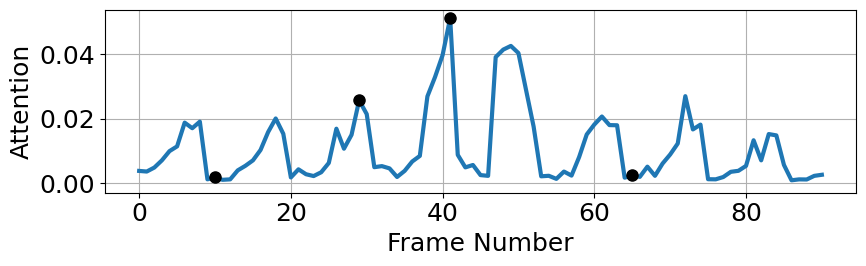

In [28]:
index = 149
batch_ix = index // bs_test
ix_in_batch = index % bs_test

mask = mask_ls[batch_ix][...,ix_in_batch]
attn = attn_ls[batch_ix][...,ix_in_batch]
trg_type = int(target_ls[batch_ix][ix_in_batch])
target = VideoData.inv_type_map[trg_type]
view = VideoData.inv_view_map[int(view_ls[batch_ix][ix_in_batch])]
external_id = externalid_ls[index]

mp4_path = df_test.loc[(df_test.external_id == external_id) & (df_test.trg_type == trg_type)].mp4_path.unique().item()
mp4_path = mp4_path.replace('/Superior Views/', '/superior_views_h264/')

print(external_id, target, view, sep=' - ')

plt.rcParams['font.size']=18
points = [10, 29, 41, 65]
plt.plot(attn[mask], linewidth=3)
plt.plot(points, attn[mask][points], 'ko', markersize=8)
plt.ylim(-0.003,None)
plt.xlabel("Frame Number")
plt.ylabel("Attention")
plt.gcf().set_size_inches(9,3)
plt.grid()
plt.tight_layout()
plt.savefig('/home/dane2/Code/pda_detection/attention.png', dpi=500)
plt.show()

images = \
    df_test.loc[(df_test.external_id == external_id) & (df_test.trg_type == trg_type), 'png_path'].\
    sort_values().iloc[points].tolist()

# save images
import shutil
for im in images:
    shutil.copy(im, '/home/dane2/Code/pda_detection/')

In [ ]:
# from IPython.display import FileLink
!cp $mp4_path /home/dane2/Code/pda_detection/

In [29]:
images

['/zfs/wficai/pda/model_data/20220901/nopda_study32_dicom83_frame0010.jpg',
 '/zfs/wficai/pda/model_data/20220901/nopda_study32_dicom83_frame0029.jpg',
 '/zfs/wficai/pda/model_data/20220901/nopda_study32_dicom83_frame0041.jpg',
 '/zfs/wficai/pda/model_data/20220901/nopda_study32_dicom83_frame0065.jpg']